In [10]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from graph_vae.vae import GraphVAE
from data_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
include_hydrogen = False
refresh_data_cache = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_list = [
    SelectQM9TargetProperties(properties=["homo", "lumo"]),
    SelectQM9NodeFeatures(features=["atom_type"]),
]
if not include_hydrogen:
    transform_list.append(DropQM9Hydrogen())

max_num_nodes = 29 if include_hydrogen else 9
transform_list += [
    AddAdjacencyMatrix(max_num_nodes=max_num_nodes),
    AddNodeAttributeMatrix(max_num_nodes=max_num_nodes),
    AddEdgeAttributeMatrix(max_num_nodes=max_num_nodes),
    # DropAttributes(attributes=["z", "pos", "idx", "name"]),
]

pre_transform = T.Compose(transform_list)
transform = T.ToDevice(device=device)

dataset = QM9(root="./data", pre_transform=pre_transform, pre_filter=qm9_pre_filter, transform=transform)

train_dataset, val_dataset, test_dataset = create_qm9_data_split(dataset=dataset)

In [12]:
batch_size = 4096
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
}

In [20]:
# load model
checkpoint_path = "./checkpoints/graph_vae_20240110_095239.pt"
graph_vae_model = GraphVAE.from_pretrained(checkpoint_path).to(device=device)

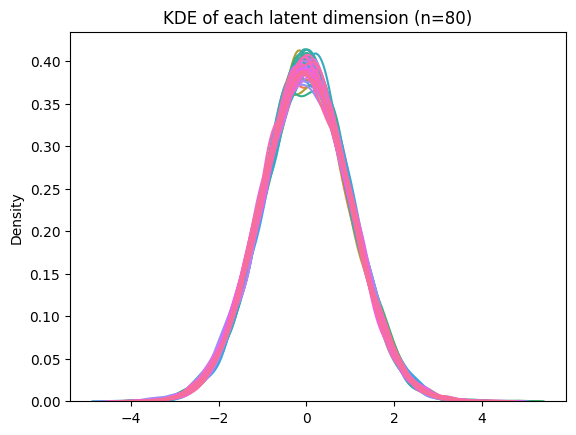

In [21]:
graph_vae_model.eval()

val_loader = dataloaders["val"]
val_batch = next(iter(val_loader))
z = graph_vae_model.encode(val_batch).detach().cpu()

latent_dim = graph_vae_model.latent_dim
for dim in range(z.shape[1]):
    sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])

plt.title(f'KDE of each latent dimension (n={latent_dim})')
plt.show()